# Firstlevel analysis 
steps
- Extract onset times of stimuli from TVA file
- Specify the model (TR, high pass filter, onset times, etc.)
- Specify contrasts to compute
- Estimate contrasts

In [3]:
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.fsl import FLIRT
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
import nipype.interfaces.spm as spm
from nipype.interfaces.base import Bunch
from nipype.interfaces.freesurfer import ApplyVolTransform, MRIConvert

In [4]:
# SPM standalone
matlab_cmd = '/usr/local/spm12/run_spm12.sh /usr/local/MATLAB/MATLAB_Compiler_Runtime/v713 script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

# experiment parameter

In [3]:
experiment_dir = '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives'
output_dir = 'firstlevel/output_firstlevel'
working_dir = 'firstlevel/working_firstlevel'

# list of subject identifiers
#subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
subject_list = ['sub-00','sub-01']

# TR of functional images
TR = 1.5
number_of_slices = 25
fwhm_size = 2

# specify contrasts

In [4]:
# Condition names
condition_names = ['punk', 'alternative', 'heavymetal', 'psychedelic', 
                   'rocknroll', 'funk', 'rnb', 'soul', 'hiphop', 
                   'reggae', 'renaissance', 'classic', 'baroque', 
                   'romantic', 'modernclassic', 'techno', 'dubstep', 
                   'trance', 'deephouse', 'drumandbass']

# Contrasts
cont01 = ['alternative',    'T', condition_names, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont02 = ['punk',           'T', condition_names, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont03 = ['heavymetal',     'T', condition_names, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont04 = ['rocknroll',      'T', condition_names, [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont05 = ['psychedelic',    'T', condition_names, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont06 = ['baroque',        'T', condition_names, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont07 = ['classic',        'T', condition_names, [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont08 = ['modernclassic',  'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont09 = ['renaissance',    'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont10 = ['romantic',       'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont11 = ['deephouse',      'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont12 = ['drumnbass',      'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont13 = ['dubstep',        'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont14 = ['techno',         'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont15 = ['trance',         'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont16 = ['funk',           'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont17 = ['hiphop',         'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cont18 = ['reggae',         'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
cont19 = ['rnb',            'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]
cont20 = ['soul',           'T', condition_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]
cont21 = ['average',        'T', condition_names, [1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20., 1/20.]]


contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09, cont10, cont11, cont12, cont13, cont14, cont15, cont16, cont17, cont18, cont19, cont20, cont21]

# specify GLM
we need information of events.tsv-files to create GLM

In [5]:
# to look into an example events.tsv-file

import pandas as pd
trialinfo = pd.read_table('/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/sub-00/func/sub-00_task-NC2U_run-1_events.tsv')
trialinfo

,onset,duration,pause,stimuli,run_type
0,0.334726,6,8,hiphop,4
1,13.475266,6,8,psychedelic,4
2,26.983692,6,8,reggae,4
3,40.492477,6,6,rnb,4
4,52.500149,6,6,psychedelic,4
5,64.474678,6,4,soul,4
6,74.981445,6,6,funk,4
7,86.989151,6,8,deephouse,4
8,100.497963,6,8,hiphop,4
9,113.973381,6,6,trance,4


In [6]:
from nipype.interfaces.base import Bunch
def get_subject_info(subject_id):
    from os.path import join as opj
    import pandas as pd
    from nipype.interfaces.base import Bunch
    path = '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/%s/func'%subject_id
    for run in ['1', '2', '3', '4', '5', '6', '7', '8']:
        file = pd.read_table(opj(path, subject_id+'_task-NC2U_'+'run-'+run+'_events.tsv'))
        # sort stimuli/rows so that they are in the same order like in the behavioral experiments
        file['stimuli_cat'] = pd.Categorical(file['stimuli'], categories=['alternative', 'punk',  'heavymetal', 'rocknroll',  'psychedelic', \
                  'baroque', 'classic',  'modernclassic',  'renaissance',  'romantic',  \
                  'deephouse',  'drumandbass', 'dubstep',  'techno',  'trance',  \
                  'funk', 'hiphop',  'reggae',  'rnb', 'soul'], ordered=True)
        sorted_file = file.sort_values('stimuli_cat')

        # create lists for each run including the stimuli and their particular onset times
        onset_array = []
        duration_array = []
        stimuli_array = []
        for group in sorted_file.groupby('stimuli', sort=False):
            stimuli_array.append(group[0])
            onset_array.append(list(round(group[1].onset,1)))
            duration_array.append(group[1].duration.tolist())
        if run == '1':
            info_run1 = [stimuli_array, onset_array, duration_array]
        elif run == '2':
            info_run2 = [stimuli_array, onset_array, duration_array]
        elif run == '3':
            info_run3 = [stimuli_array, onset_array, duration_array]
        elif run == '4':
            info_run4 = [stimuli_array, onset_array, duration_array]
        elif run == '5':
            info_run5 = [stimuli_array, onset_array, duration_array]
        elif run == '6':
            info_run6 = [stimuli_array, onset_array, duration_array]
        elif run == '7':
            info_run7 = [stimuli_array, onset_array, duration_array]
        elif run == '8':
            info_run8 = [stimuli_array, onset_array, duration_array]
        else:
            print(info_run_error)

    # create subject_info including all runs
    subject_info=[]
    for r in range(8):
        if r == 0:
            subject_info.insert(r,
                                (Bunch(conditions=info_run1[0],
                                 onsets = info_run1[1],
                                 durations = info_run1[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))   
        elif r == 1:
            subject_info.insert(r,
                                (Bunch(conditions=info_run2[0],
                                 onsets = info_run2[1],
                                 durations = info_run2[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None))) 
        elif r == 2:
            subject_info.insert(r,
                                (Bunch(conditions=info_run3[0],
                                 onsets = info_run3[1],
                                 durations = info_run3[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))
        elif r == 3:
            subject_info.insert(r,
                                (Bunch(conditions=info_run4[0],
                                 onsets = info_run4[1],
                                 durations = info_run4[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))
        elif r == 4:
            subject_info.insert(r,
                                (Bunch(conditions=info_run5[0],
                                 onsets = info_run5[1],
                                 durations = info_run5[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))
        elif r == 5:
            subject_info.insert(r,
                                (Bunch(conditions=info_run6[0],
                                 onsets = info_run6[1],
                                 durations = info_run6[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))
        elif r == 6:
            subject_info.insert(r,
                                (Bunch(conditions=info_run7[0],
                                 onsets = info_run7[1],
                                 durations = info_run7[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))
        elif r == 7:
            subject_info.insert(r,
                                (Bunch(conditions=info_run8[0],
                                 onsets = info_run8[1],
                                 durations = info_run8[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))
        else: 
            print("error2")          
            
    return(subject_info)

# get subject info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=get_subject_info),
                      name='getsubjectinfo')

# specify nodes

In [7]:
# Nodes used in the nipype beginners guide and the handson example

# SpecifyModel - Generates SPM-specific Model (output: session infos for level1design)
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=256),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix (output: spm mat file)
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}}, #basis function (hrf)
                                 timing_units='secs',               # model time derivatives
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'), # model the serial correlation with AR(1) 
                                                                    #(Serial correlations in fMRI time series due to aliased 
                                                                    # biorhythms and unmodelled neuronal activity can be accounted 
                                                                    #for using an autoregressive AR(1) model)
                    name="level1design")

# EstimateModel - estimate the parameters of the model (output: a.o. beta-images)
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}), # other option would be Bayesian
                      name="level1estimate")

# EstimateContrast - estimates contrasts (output: o.a. con_images (t-maps))
level1conest = Node(EstimateContrast(contrasts=contrast_list), name="level1conest")

# Volume Transformation - transform contrasts into anatomical space
#applyVolReg = MapNode(ApplyVolTransform(fs_target=True),
#                      name='applyVolReg',
#                      iterfield=['source_file'])

# MRIConvert - to gzip output files
#mriconvert = MapNode(MRIConvert(out_type='niigz'),
#                     name='mriconvert',
#                     iterfield=['in_file'])

# specify input and output stream

In [8]:
# Selectfiles - to grab the data
templates = {'anat': '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/{subject_id}/mri/brain.mgz', # anatomical images,
             'func': '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/smooth/_subject_id_{subject_id}/s{subject_id}_*.nii',
             'mc_param': '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/realign/_subject_id_{subject_id}/rp_{subject_id}*.txt',
             'outliers': '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/art/_subject_id_{subject_id}/art.r{subject_id}_*.txt',
             'mask' : '/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/masks/_subject_id_{subject_id}/_aparc_robust_BET_mask0/aparc_robust_BET.nii'
            }


selectfiles = Node(SelectFiles(templates, sort_filelist=True),
          name='selectfiles')

#selectfiles.iterables = [('subject_id', subject_list)]

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'contrasts',
                                            'mask'],
                                    contrasts=contrast_list),
                  name="infosource")

infosource.iterables = [('subject_id', subject_list)]

# Initiate the datasink node
output_folder = output_dir
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_folder),
                name="datasink")

## Use the following substitutions for the DataSink output
substitutions = [('_subj_id_', 'sub-')]
subjFolders = [('s%s' % (sub), '%s' % (sub))
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Use the following substitutions for the DataSink output
#substitutions = [('_subj_id_', 'sub-')]
#datasink.inputs.substitutions = substitutions

# specify workflow

In [9]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('mask', 'mask')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (infosource, getsubjectinfo, [('subject_id', 'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                 'subject_info')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters')]),
                    (selectfiles, level1design, [('mask', 'mask_image')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1estimate, datasink, [('mask_image', 'contrasts.@masks')]),
                    #(level1conest, applyVolReg, [('con_images',
                    #                             'source_file')]),
                    #(applyVolReg, mriconvert, [('transformed_file',
                    #                            'in_file')]),
                    #(mriconvert, datasink, [('out_file', 'contrasts.@contrasts')]),
                    (level1conest, datasink, [('spm_mat_file','contrasts.@spm_mat'),
                                              ('spmT_images', 'contrasts.@T'),
                                              ('con_images', 'contrasts.@con')]),
                    ])

# visualize workflow

180723-16:14:18,241 workflow INFO:
	 Generated workflow graph: /home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/graph.png (graph2use=colored, simple_form=True).


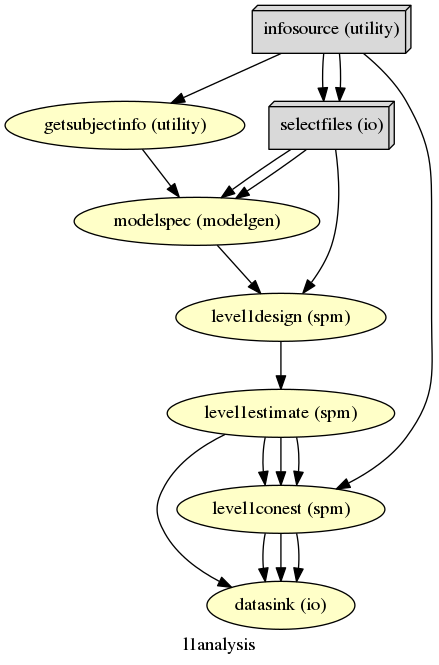

In [19]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image('/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/graph.png')

# run workflow

In [10]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 2})

180806-10:25:07,774 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
180806-10:25:07,925 workflow INFO:
	 Running in parallel.
180806-10:25:07,997 workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 10.45/10.45, Free processors: 2/2.
180806-10:25:08,105 workflow INFO:
	 [Job 1] Cached (l1analysis.getsubjectinfo).
180806-10:25:08,105 workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-01/selectfiles".
180806-10:25:08,151 workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
180806-10:25:08,743 workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
180806-10:25:09,988 workflow INFO:
	 [Job 0] Completed (l1analysis.selectfiles).
180806-10:25:09,998 workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 10.45/10.45, Free processors: 

180806-10:44:14,80 workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
180806-10:44:15,368 workflow INFO:
	 [Job 12] Completed (l1analysis.level1conest).
180806-10:44:15,377 workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 10.45/10.45, Free processors: 2/2.
180806-10:44:15,464 workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-00/datasink".
180806-10:44:15,470 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
180806-10:44:15,487 workflow INFO:
	 [Node] Finished "l1analysis.datasink".
180806-10:44:17,371 workflow INFO:
	 [Job 13] Completed (l1analysis.datasink).
180806-10:44:17,380 workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 10.45/10.45, Free processors: 2/2.


# output visualization in nipype-example

In [21]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

In [22]:
# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1design/SPM.mat',
                 struct_as_record=False)

In [23]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

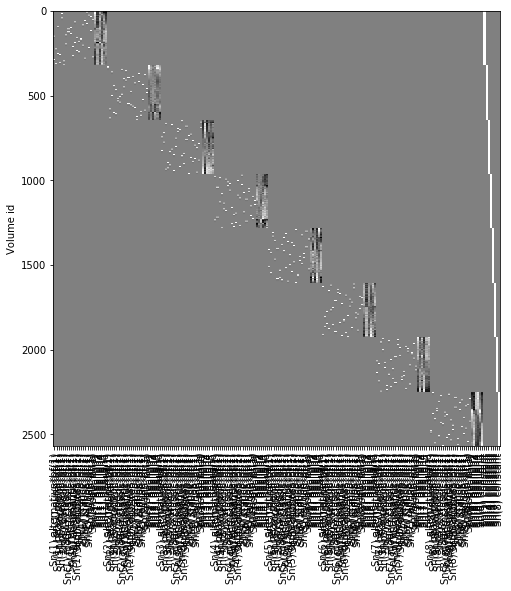

In [24]:
# plot matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

# visualization 

In [6]:
%matplotlib inline
from nilearn.plotting import plot_stat_map

# plot t-map alternative
#plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0001.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=1, cut_coords=(-50, 10, 0))

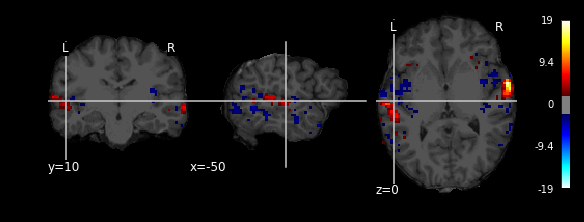

In [26]:
# plot t-map punk
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0002.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

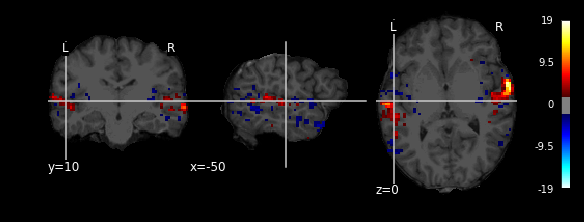

In [27]:
# plot t-map heavymetal
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0003.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

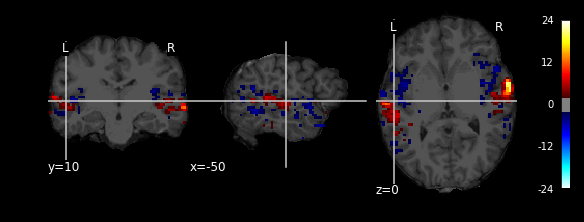

In [28]:
# plot t-map renaissance
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0009.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

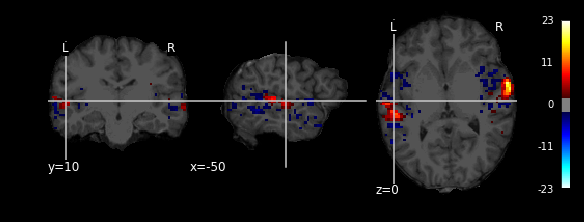

In [29]:
# plot t-map techno
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0014.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

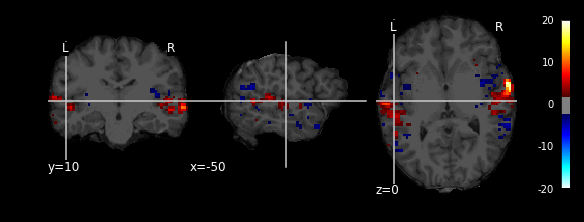

In [30]:
# plot t-map soul
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0020.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

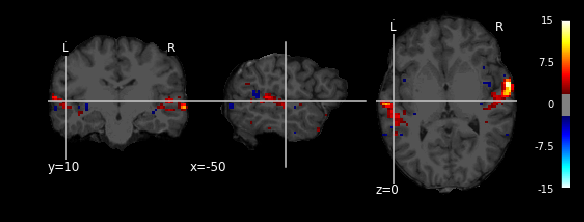

In [7]:
# plot t-map funk
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0016.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

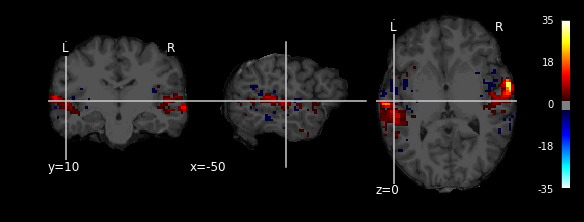

In [8]:
# plot t-map hiphop
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0017.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

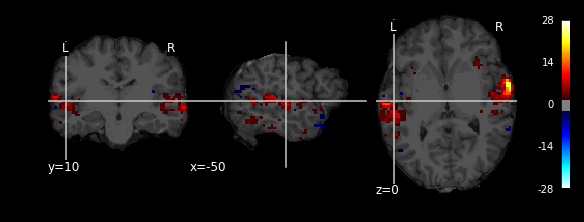

In [9]:
# plot t-map reggae
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0018.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))

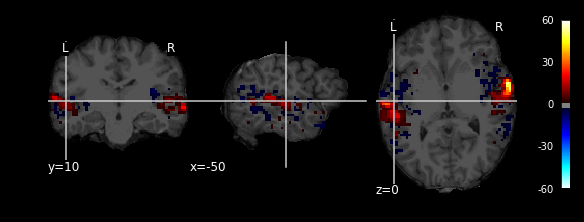

In [31]:
# plot t-map average
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/preprocessing/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0021.nii', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0))